- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   

## Chapter 9 - Hierarchical Models

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

### 9.2.4 - Example: Therapeutic touch

In [2]:
df = pd.read_csv('data/TherapeuticTouchData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
y    280 non-null int64
s    280 non-null object
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


#### Figure 9.9

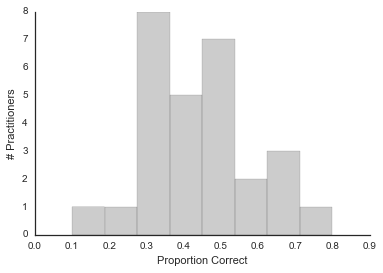

In [3]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = sns.distplot(df_proportions, bins=8, kde=False, color='gray')
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners')
sns.despine(ax=ax);

#### Model

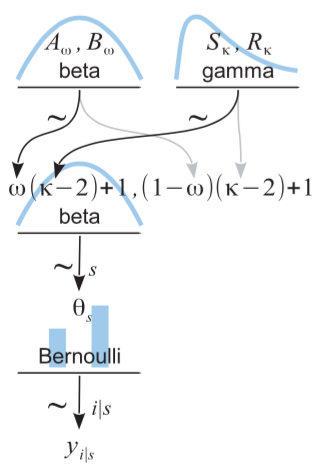

In [4]:
Image('images/fig9_7.png', width=250)

In [5]:
with pmc.Model() as hierarchical_model:
    omega = pmc.Beta('omega', 2, 2)
    kappa = pmc.Gamma('kappa', 1, 0.01)
    
    theta = pmc.Beta('theta', omega*(kappa-2)+1, (1-omega)*(kappa-2)+1, shape=df.s.size)
    
    y = pmc.Bernoulli('y', theta, observed=df.y)    

Applied logodds-transform to omega and added transformed omega_logodds to model.
Applied log-transform to kappa and added transformed kappa_log to model.
Applied logodds-transform to theta and added transformed theta_logodds to model.


In [6]:
with hierarchical_model:
    start = pmc.find_MAP()
    step = pmc.NUTS(state=start)
       
    trace= pmc.sample(1000, step, start=start)

 [-----------------100%-----------------] 1000 of 1000 complete in 21.2 sec

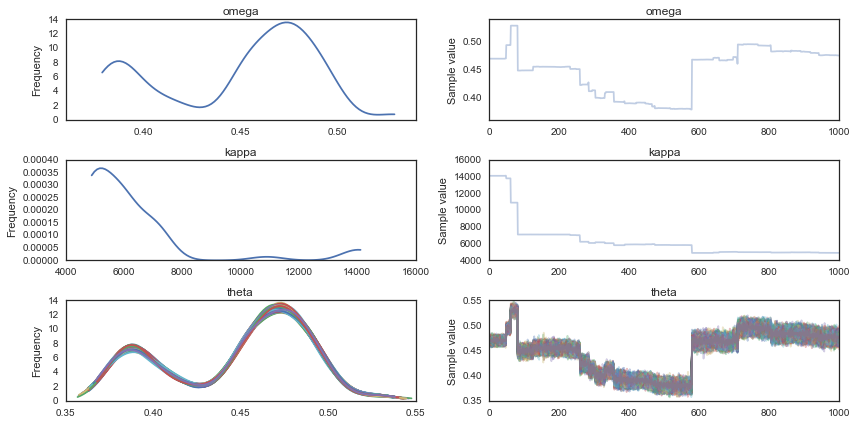

In [7]:
pmc.traceplot(trace);